Need access to an A100 GPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
!pip install -q wandb -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
from datasets import load_dataset

#Model dataset 1
"""
train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/validation.jsonl', split='train')
"""

#Model with new dataset
train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/v2_dataset/train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/v2_dataset/validation.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)


Use Weights & Biases to track our training metrics (`wandb`).

In [5]:
import wandb, os
wandb.login()

wandb_project = "diss-mistral-v3-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Formatting prompts
Create a `formatting_func` to structure training examples as prompts. The current dataset has a input formatted as a question, and output is the answer. This function takes an example containing an input question and its corresponding output answer. It formats them into a structured prompt where the question is prefixed with "### Question:" and the answer is prefixed with "### Answer:". This way, the model can understand the structure of the input and output in relation to each other.


In [7]:
"""def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text"""
def formatting_func(example):
    text = f"Question: {example['input']}\n\n Answer: {example['output']}"
    return text

### Load Base Model

Load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization from huggingface

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

To decide the `model_max_length` for our input tensors, we should first understand the distribution of our current data's length's. We want to know how many tokens are in each of our prompts. Once we visualize this distribution, we can then decide `model_max_length`.

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/3408 [00:00<?, ? examples/s]

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

3787


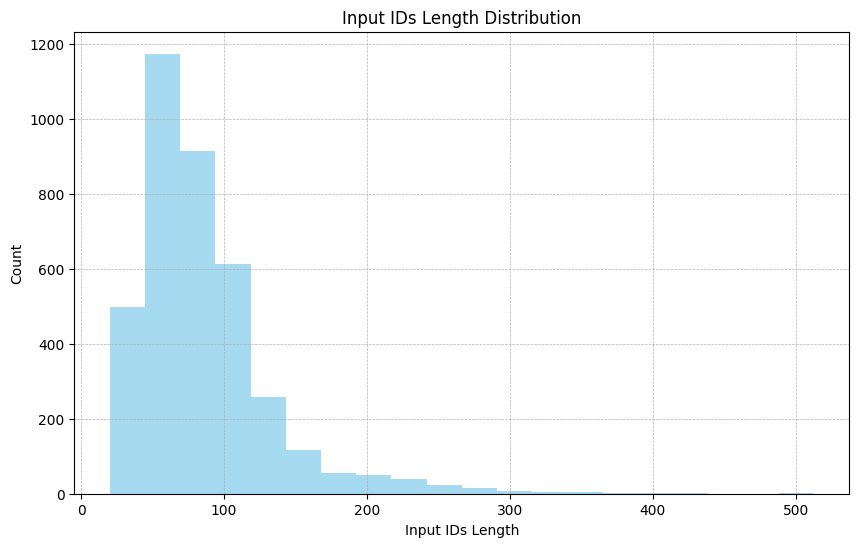

In [11]:

import matplotlib.pyplot as plt

def display_input_id_distribution(train_dataset, val_dataset):
    # Combining and calculating lengths in one step
    all_lengths = [len(record['input_ids']) for dataset in [tokenized_train_dataset, tokenized_val_dataset] for record in dataset]
    print(len(all_lengths))

    # Plotting with a slight style variation
    plt.figure(figsize=(10, 6))
    plt.hist(all_lengths, bins=20, alpha=0.75, color='skyblue')
    plt.xlabel('Input IDs Length')
    plt.ylabel('Count')
    plt.title('Input IDs Length Distribution')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

display_input_id_distribution(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
# Assuming all_lengths is already calculated as before
all_lengths = [len(record['input_ids']) for dataset in [tokenized_train_dataset, tokenized_val_dataset] for record in dataset]

# Filtering lengths greater than 200 and counting them
lengths_above_200 = [length for length in all_lengths if length > 200]
print(f"Number of inputs with length of input_ids above 200: {len(lengths_above_200)}")

# Filtering lengths greater than 300 and counting them
lengths_above_256 = [length for length in all_lengths if length > 300]
print(f"Number of inputs with length of input_ids above 300: {len(lengths_above_256)}")


Number of inputs with length of input_ids above 200: 136
Number of inputs with length of input_ids above 300: 19


As we can see, almost all of our inputs have less than 300 tokens. Hence, we will pad inputs to 300, and truncate the inputs that have more than 300 to 300 tokens.

Now tokenize with padding and truncation, and set up the tokenize function to make labels and input_ids the same.

In [17]:
max_length = 300

def generate_and_tokenize_prompt_w_padding_trunc(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [18]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt_w_padding_trunc)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt_w_padding_trunc)

Map:   0%|          | 0/3408 [00:00<?, ? examples/s]

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

As we can see `input_ids` is padded on the left with the `eos_token` (2). Once the padding with (2)'s is finished, before the prompt starts, a `bos_token` is inserted, then the prompt is tokenized, and then finished with one more `eos_token`.

In [19]:
print(tokenized_train_dataset[1]['input_ids'])
print(tokenized_train_dataset[1]['input'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 22478, 28747, 1824, 460, 272, 1945, 3926, 1938, 272, 430, 19525, 5430, 302, 2367, 9795, 28804, 13, 13, 26307, 28747, 6213, 272, 430, 19525, 302, 2367, 9795, 28725, 16007, 2195, 1115, 4544, 304, 24448, 385, 28548, 2076, 1058, 28725, 7888, 9141, 916, 264, 7817, 6794, 28723, 689, 436, 385, 28548, 28725, 14333, 2458, 302, 2652, 299, 1944, 15792, 5668, 24448, 270, 2298, 28725, 460, 7298, 438, 264, 1595, 436, 397, 28723, 8144, 1360, 1595, 2737, 28548, 2318, 298, 272, 9089, 1160, 274, 302, 272, 3601, 304, 1221, 

Now all the samples should be the same length, `max_length`.

3787


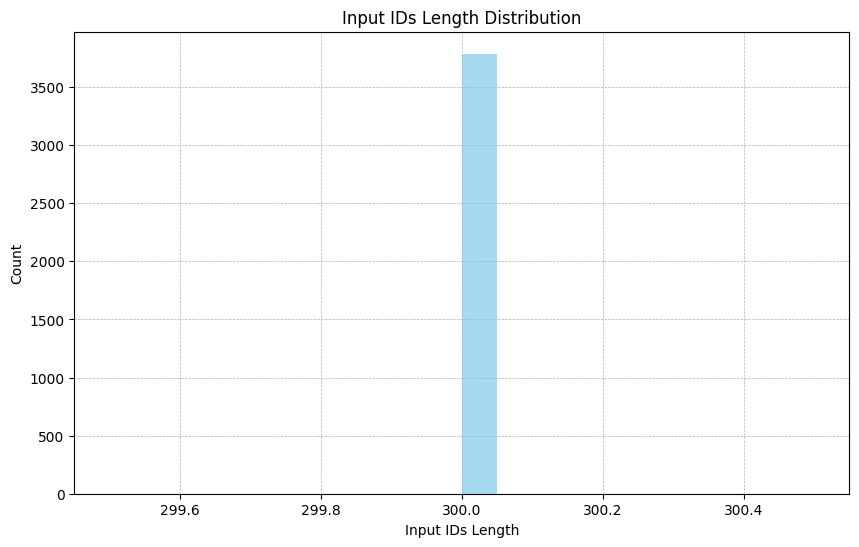

In [20]:
display_input_id_distribution(tokenized_train_dataset, tokenized_val_dataset)

### Mistral Base model on three eval_prompts

Just to get a quick unofficial idea of how fine tuned model does versus the vanilla model, we can print a few mistral generations using three eval prompts. One that tests its ability on understanding specific topics, one paper 2 question, and a multiple choice paper 1 question.

In [ ]:
eval_prompt_1 = "Question: What is the Davson-Danielli model?"
#Completion: The Davson-Danielli model is a lipo-protein sandwich model that assumed all membranes were of a uniform thickness with a constant lipid-protein ratio, and it assumed all membranes would have symmetrical internal and external surfaces. It did not account for the permeability of certain substances and did not recognize the need for hydrophilic pores. The temperatures at which membranes solidified did not correlate with those expected under this model."

eval_prompt_2="Question:What is the role of cells in the defence against infectious disease? [7 marks]"
"""
Output: Answer:

Cells of skin provide a physical barrier/produce fatty acids/lactic acid/lysozyme which stops entry of microbes, or mucous membranes produce mucus to trap pathogens. Also, stomach cells produce hydrochloric acid which kills microbes.
Platelets start the clotting process preventing access of pathogens.
Two types of white blood cells fight infections in the body.
Phagocytes ingest pathogens by endocytosis/phagocytosis and give non-specific immunity to diseases.
Antibodies are produced by lymphocytes/B cells in response to particular pathogens/antigens, giving specific immunity.
Lymphocyte/B cell makes only one type of antibody, and plasma cells produce a large quantity of one type of antibody.
Some lymphocytes act/remain as memory cells and can quickly reproduce to form a clone of plasma cells if a pathogen carrying a specific antigen is re-encountered, resulting in faster defence against second exposure to specific antigen/pathogen/disease."""

eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer with only the correct letter!
Answer:"""
#D

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(model.generate(**model_input_1, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n\n")


model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(model.generate(**model_input_2, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n\n")


model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(model.generate(**model_input_3, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: What is the Davson-Danielli model?

Answer: The Davson-Danielli model was proposed in 1950 by two scientists, Davson and Danielli. It describes the structure of a cell membrane as being composed of three layers: an inner layer called the cytoplasmic face, an outer layer called the extracellular face, and a middle layer called the hydrophobic core. This model has been widely accepted for many years but recent research suggests that it may not be entirely accurate. For example, some studies have shown that there are actually four layers to the cell membrane rather than three. Additionally, the Davson-Danielli model does not take into account the fact that cells can change their shape and size depending on their environment. Despite these limitations, the Davson-Danielli model remains one of the most popular models used today to describe how cells work.



Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks]

Answer:

Cells are the basic structural and functional unit of all living organisms. They are the building blocks for life. Cells contain hereditary information, metabolize nutrients, respond to their environment, and reproduce. The human body contains trillions of cells that make up tissues and organs. There are many different types of cells that each have a specific function. For example, red blood cells carry oxygen throughout the body, while white blood cells help fight off infection.

The immune system is made up of specialised cells that work together to protect the body from foreign invaders such as bacteria, viruses, and other harmful substances. When these invaders enter the body, they trigger an immune response which involves the production of antibodies by B-cells and the activation of T-cells. These cells then destroy the invading pathogens.

In addition to fighting off infection, cells

### Set Up LoRA

Apply  preprocessing to Mistral in order to prepare it for training. For that we use the `prepare_model_for_kbit_training` method from PEFT.

In [21]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [22]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,#32,
    lora_alpha=32,#64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    use_rslora=True,
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 42520576 || all params: 3794591744 || trainable%: 1.1205573318192514


### Training

In [25]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [26]:
model = accelerator.prepare_model(model)

In [27]:
import torch
print(torch.__version__)
print(torch.version.cuda)

!nvidia-smi


2.2.1+cu121
12.1
Tue Apr 16 11:38:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              51W / 400W |   6247MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+--------

In [28]:
import transformers
from datetime import datetime

#project = "ib-bio-v3" #this was the last run for mistral v1
project = "ib-bio-v1"
base_model_name = "mistral-v3"
run_name = base_model_name + "-" + project
#output_dir = "./" + run_name
output_dir= "/content/drive/MyDrive/Arunadiss/main/Finetune/model/mistral/logs/"+ run_name
logging_dir="/content/drive/MyDrive/Arunadiss/main/Finetune/model/mistral/logs"

# Check if the directory exists
if not os.path.exists(output_dir):
    # Create the directory if it doesn't exist
    os.makedirs(output_dir)

print("Output directory created:", output_dir)

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,#8,#2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        #max_steps=-1,#500,#
        num_train_epochs=6,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=125,#25,              # When to start reporting loss
        logging_dir=logging_dir,#"./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=250,#25,                # Save checkpoints every 250 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=250,#25,               # Evaluate 250 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run
        #use_reentrant=True  # Explicitly setting use_reentrant to suppress the checkpoint warning
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings
trainer.train()

Output directory created: /content/drive/MyDrive/Arunadiss/main/Finetune/model/mistral/logs/mistral-v3-ib-bio-v1


wandb: Currently logged in as: alexkstern (alexksternteam). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
250,1.375300,1.345872
500,1.343900,1.319000
750,1.270400,1.289987
1000,1.258200,1.279262
1250,1.297300,1.255150
1500,1.235100,1.244288
1750,1.054700,1.294244
2000,0.747100,1.313913
2250,0.732500,1.321248
2500,0.734300,1.314181


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=10224, training_loss=0.4921955255462157, metrics={'train_runtime': 7813.8071, 'train_samples_per_second': 2.617, 'train_steps_per_second': 1.308, 'total_flos': 2.632828290859008e+17, 'train_loss': 0.4921955255462157, 'epoch': 6.0})

In [29]:
wandb.finish()

eval/loss,▂▂▁▁▁▁▁▁▂▁▁▁▁▃▃▃▃▃▃▃▅▅▄▅▅▄▄▆▆▆▆▆▆▆██████
eval/runtime,█▆▄▄▆▄▃▆▅▆▆▆▆▅▆▆▆▅▂▆▃▁▃▃█▅▂▂▃▂▁▃▃▄▄▂▁▃▅▅
eval/samples_per_second,▁▃▅▅▃▅▆▃▄▃▃▃▃▄▃▃▃▄▇▃▆█▇▆▁▄▇▇▆▇█▆▆▅▅▇█▆▄▄
eval/steps_per_second,▁▃▅▅▃▅▆▃▅▃▃▃▃▃▃▃▃▅▆▃▆█▆▆▁▅█▆▆▆█▆▆▆▅██▆▅▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▅▅▅█▄▃▄▄▃▅▅▅▅▄▅▅▅▅▄▃▄▄▃▃▇▄▃▁▅▂█▄▂▂▂▂▄▂▁▁
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,██▇▇▇▇▇▄▅▄▄▄▄▄▂▂▂▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,2.25709
eval/runtime,20.1886


As we can see model started to overfit, and eventually validation loss started increasing after step 3900. Hence, we will chose our checkpoint closest to this step.

### Use the Trained Model


In [30]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
#model.config.use_cache = True

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [39]:
from peft import PeftModel

pth_2000="/content/drive/MyDrive/Arunadiss/main/Finetune/model/mistral/logs/mistral-v3-ib-bio-v1/checkpoint-2000"
pth_8000="/content/drive/MyDrive/Arunadiss/main/Finetune/model/mistral/logs/mistral-v3-ib-bio-v1/checkpoint-8000"
ft_model = PeftModel.from_pretrained(base_model, pth_8000)

In [33]:
eval_prompt_1 = "Question: What is the Davson-Danielli model? Answer:"
#Completion: The Davson-Danielli model is a lipo-protein sandwich model that assumed all membranes were of a uniform thickness with a constant lipid-protein ratio, and it assumed all membranes would have symmetrical internal and external surfaces. It did not account for the permeability of certain substances and did not recognize the need for hydrophilic pores. The temperatures at which membranes solidified did not correlate with those expected under this model."

eval_prompt_2="Question:What is the role of cells in the defence against infectious disease? [7 marks] Answer:"
"""
Output: Answer:

Cells of skin provide a physical barrier/produce fatty acids/lactic acid/lysozyme which stops entry of microbes, or mucous membranes produce mucus to trap pathogens. Also, stomach cells produce hydrochloric acid which kills microbes.
Platelets start the clotting process preventing access of pathogens.
Two types of white blood cells fight infections in the body.
Phagocytes ingest pathogens by endocytosis/phagocytosis and give non-specific immunity to diseases.
Antibodies are produced by lymphocytes/B cells in response to particular pathogens/antigens, giving specific immunity.
Lymphocyte/B cell makes only one type of antibody, and plasma cells produce a large quantity of one type of antibody.
Some lymphocytes act/remain as memory cells and can quickly reproduce to form a clone of plasma cells if a pathogen carrying a specific antigen is re-encountered, resulting in faster defence against second exposure to specific antigen/pathogen/disease."""

eval_prompt_3="""Question: What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer:"""
#D

#### V3 dataset Model 1

##### checkpoint-2000

V3 dataset Model 1

In [34]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: What is the Davson-Danielli model? Answer: The Davson-Danielli model was proposed in 1950 by two scientists, Davson and Danielli. It describes the structure of a cell membrane as being composed of three layers: an inner layer called the cytoplasmic face, an outer layer called the extracellular face, and a middle layer called the hydrophobic core.

The Davson-Danielli model also includes a fourth component – the lipid bilayer – which is made up of phospholipids that are arranged in such a way that their polar heads point outwards towards the water while their nonpolar tails point inwards towards each other. This arrangement allows for the passage of molecules through the membrane without disrupting its integrity.

## What is the Davson-Danielli model?

The Davson-Danielli model is a theoretical model of the cell membrane that was first proposed in 1

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks] Answer:

Cells are the basic structural and functional unit of all living organisms. They are the smallest units that can carry out life processes such as metabolism, growth and reproduction. Cells are made up of a cell membrane which encloses cytoplasm containing various organelles. The nucleus contains genetic material (DNA) and controls the activities of the cell.

The main function of cells is to provide protection for the body from invading microorganisms. This is done by the following mechanisms:

1. Physical barriers
2. Chemical

##

Eval 3:


Question: What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer: D

Question:

##



In [35]:
eval_prompt= 'What are the three main processes that promote variation within a population?\nAnswer:'
""""The three main processes that promote variation within a population are gene mutations,
which change the genetic composition of an organism due to alterations in the DNA base sequence,
sexual reproduction, which introduces new gene combinations in offspring via random mating and meiotic divisions,
and gene flow, which is the movement of alleles into or out of a population as a result of immigration or emigration."""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


What are the three main processes that promote variation within a population?
Answer: Mutation, Recombination and Natural Selection.
What is mutation?
Mutations are changes in DNA sequence that occur spontaneously or as a result of exposure to radiation or chemicals.
How do mutations cause genetic variation?
Mutations can change the nucleotide sequence of genes, which may alter the amino acid sequence of proteins encoded by those genes. This can lead to altered protein function, which can have many different effects on an organism’s phenotype

##



In [36]:
eval_prompt= 'Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]\nAnswer:'
""""- Gene pool is all genes/all alleles. Reject all alleles/genes in a species.\n
- Geographic isolation Reject isolation if no type of isolation given. OR migration to different areas OR temporal isolation OR behavioural isolation\n
- Speciation/gene pool split if populations are reproductively isolated/do not interbreed\n
- In different environments there are different selection pressures/opportunities/natural selection/adaptations/niches «to exploit»\n
- Allele frequencies change/diverge Reject gene frequencies."""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]
Answer: The concept of gene pool is based on the idea that all individuals in a population share common genes and are therefore genetically similar to each other. This means that they can interbreed with one another and produce offspring that are also part of the same population. However, over time, genetic differences between individuals within a population may arise due to mutations or other factors such as natural selection. These genetic differences can lead to the formation of subpopulations within the larger population. Subpopulations may become isolated from one another due to geographic barriers or other factors, leading to further genetic diver

##



In [37]:
eval_prompt= 'Describe how body temperature is maintained in humans. [6 marks]\nAnswer:'
""""- maintained close to 36.7/37°C/98.6°F\n
- heat is transferred/distributed in body by blood\n
- hypothalamus contains thermoreceptors\n- hypothalamus monitors temperature/sends message to effectors/causes response\n
- (vaso) dilation of skin arterioles warms skin/cools body\n
- (vaso) constriction of skin arterioles retains body heat\n
- skin/sweat glands produce sweat to cool the body when overheated\n- removal of heat through evaporation of sweat\n
- shivering generates heat / increased metabolism / hair erection to retain heat\n
- example of behavioral change to warm/cool the body to thermoregulate"""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Describe how body temperature is maintained in humans. [6 marks]
Answer: The human body maintains a constant internal environment, known as homeostasis. This means that the body’s temperature remains at 37°C and this is achieved by the following mechanisms:
1) Sweating – when we sweat, water evaporates from our skin and takes heat with it. This cools us down.
2) Shivering – shivering causes muscles to contract rapidly which generates heat.
3) Blood vessels – blood vessels can constrict or dilate (open up). When they are constricted, less blood flows through them so less

##



In [38]:
eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer:"""
model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=3, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D



##



##### Checkpoint 8000

V3 dataset Model 1

In [40]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: What is the Davson-Danielli model? Answer: The Davson-Danielli model was proposed in 1950 by two scientists, Davson and Danielli. It describes the structure of a cell membrane as being composed of three layers: an inner layer called the cytoplasmic face, an outer layer called the extracellular face, and a middle layer called the hydrophobic core.

The Davson-Danielli model also includes a fourth component – the lipid bilayer – which is made up of phospholipids that are arranged in such a way that their polar heads point outwards towards the water while their nonpolar tails point inwards towards each other. This arrangement allows for the passage of molecules through the membrane without disrupting its integrity.

## What is the Davson-Danielli model?

The Davson-Danielli model is a theoretical model of the cell membrane that was first proposed in 1

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks] Answer:

Cells are the basic structural and functional unit of all living organisms. They are the smallest units that can carry out life processes such as metabolism, growth and reproduction. Cells are made up of a cell membrane which encloses cytoplasm containing various organelles. The nucleus contains genetic material (DNA) and controls the activities of the cell.

The main function of cells is to provide protection for the body from invading microorganisms. This is done by the following mechanisms:

1. Physical barriers
2. Chemical

##

Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D

Explan

##



In [42]:
eval_prompt= 'What are the three main processes that promote variation within a population?\nAnswer:'
""""The three main processes that promote variation within a population are gene mutations,
which change the genetic composition of an organism due to alterations in the DNA base sequence,
sexual reproduction, which introduces new gene combinations in offspring via random mating and meiotic divisions,
and gene flow, which is the movement of alleles into or out of a population as a result of immigration or emigration."""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


What are the three main processes that promote variation within a population?
Answer: Mutation, Recombination and Natural Selection.
What is mutation?
Mutations are changes in DNA sequence that occur spontaneously or as a result of exposure to radiation or chemicals.
How do mutations cause genetic variation?
Mutations can change the nucleotide sequence of genes, which may alter the amino acid sequence of proteins encoded by those genes. This can lead to altered protein function, which can have many different effects on an organism’s phenotype

##



In [43]:

eval_prompt= 'Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]\nAnswer:'
""""- Gene pool is all genes/all alleles. Reject all alleles/genes in a species.\n
- Geographic isolation Reject isolation if no type of isolation given. OR migration to different areas OR temporal isolation OR behavioural isolation\n
- Speciation/gene pool split if populations are reproductively isolated/do not interbreed\n
- In different environments there are different selection pressures/opportunities/natural selection/adaptations/niches «to exploit»\n
- Allele frequencies change/diverge Reject gene frequencies."""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]
Answer: The concept of gene pool is based on the idea that all individuals in a population share common genes and are therefore genetically similar to each other. This means that they can interbreed with one another and produce offspring that are also part of the same population. However, over time, genetic differences between individuals within a population may arise due to mutations or other factors such as natural selection. These genetic differences can lead to the formation of subpopulations within the larger population. Subpopulations may become isolated from one another due to geographic barriers or other factors, leading to further genetic diver

##



In [44]:
eval_prompt= 'Describe how body temperature is maintained in humans. [6 marks]\nAnswer:'
""""- maintained close to 36.7/37°C/98.6°F\n- heat is transferred/distributed in body by blood\n
- hypothalamus contains thermoreceptors\n- hypothalamus monitors temperature/sends message to effectors/causes response\n
- (vaso) dilation of skin arterioles warms skin/cools body\n- (vaso) constriction of skin arterioles retains body heat\n
- skin/sweat glands produce sweat to cool the body when overheated\n- removal of heat through evaporation of sweat\n
- shivering generates heat / increased metabolism / hair erection to retain heat\n
- example of behavioral change to warm/cool the body to thermoregulate"""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Describe how body temperature is maintained in humans. [6 marks]
Answer: The human body maintains a constant internal environment, known as homeostasis. This means that the body’s temperature remains at 37°C and this is achieved by the following mechanisms:
1) Sweating – when we sweat, water evaporates from our skin and takes heat with it. This cools us down.
2) Shivering – shivering causes muscles to contract rapidly which generates heat.
3) Blood vessels – blood vessels can constrict or dilate (open up). When they are constricted, less blood flows through them so less

##



In [45]:
eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer:"""
model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=3, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D



##



#### Other Models

V2 dataset 2 Model

In [ ]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=10, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: What is the Davson-Danielli model?

 Answer: The Davson-Danielli model was proposed by T. H. Davson and B. G. Danielli in 1943, based on X-ray diffraction studies of ultrathin sections of biological membranes. According to this model, membranes are composed of two layers – an inner aqueous solution (hydrophilic) layer and an outer lipid bilayer (hydrophobic). The hydrophil

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks]

 Answer: - part of immune system
- macrophage/phagocyte recognizes antigens on pathogens
- ingests/swallows pathogen (in phagocytosis)
- breaks down pathogen in lysosome
- presents antigen to other cells of the immune system
- stimulates cloning of B cells that are specific for this antigen
- B cells clone themselves to produce many identical antibody producing cells


##

Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer with only the correct letter!
Answer: None of the other choices are correct. D is

##



In [ ]:
model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")
ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=30, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


Question: What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer: D. Restoration of insulation tissue in neurons The correct answer is (d). Stem cells are used to restore insulation tissue in neur

##



V1 dataset 2 Model

In [ ]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


###Question: What is the Davson-Danielli model?? ###Answer: The Davson-Danielli model was proposed in 1935 by Frederick G. A. Danielli and Bernard Kettlewell, based on data collected by Edwin J. H. Davson. It described a lipid bilayer with protein layers above and below it. This model was used to explain membrane structure for over two decades until it was superseded by the fluid mosaic model. [Image credit: OpenStax]

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


###Question:What is the role of cells in the defence against infectious disease? [7 marks] ###Answer: - skin and mucous membranes form barriers to pathogens as first line of defence;
 ###- macrophage recognizes antigens and ingests pathogen (in blood/body tissues); presents antigen/MHC on cell surface;
- macrophage activates helper T-cells that are complementary to antigen;
- cytotoxic T-cells destroy infected body cells/macrophages containing pathogens;
- macrophages engulf and digest pathogens (non-specific immunity);
- antibodies bind to antigens on bacteria/viruses/pathogens;
- agglutination of bacteria by antibody makes them easier to remove;
- antibodies enhance phagocytosis by macrophages/neutrophils;
- antibodies block entry of viruses into animal/plant cells;
- antibodies cause lysis of

##

Eval 3:


###Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified

In [ ]:
ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


###Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer with only the correct letter!
###Answer: C. Production of gen

##



V2 dataset 1 Model

In [ ]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What is in topic 2.1 Molecules to Metabolism#
 ### 2.1 Molecules to Metabolism
- The structure of DNA and RNA are similar, but differ in the sugar component used.
- DNA has a deoxyribose backbone while RNA uses ribose.
- Both have four bases: adenine (A), cytosine (C), guanine (G), and thymine (T) for DNA or uracil (U) for RNA.
- Adenine always pairs with thymine/uracil, cytosine always pairs with guanine, and guanine always pairs with cytosine.
- These base pairings form rungs on the ladder-like structure of DNA and RNA.
- DNA is more stable than RNA due to its lack of oxygen in the sugar component.
- DNA can be replicated using polymerase enzymes, while RNA cannot.
- DNA is found in all living organisms, while RNA is only present in cells that synthesize proteins.
- DNA is stored in chromosomes within the nucleus, while RNA is found in the cytoplasm.
- DNA is transcribed into

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What is the role of cells in the defence against infectious disease? Mention 7 points. Answer:

- Cells are the first line of defense against infection.
- They have a cell wall or membrane that prevents entry of pathogens.
- Phagocytes engulf and digest foreign bodies, including bacteria.
- Macrophages ingest dead cells and debris.
- Lymphocytes produce antibodies to fight specific diseases.
- Antibodies attach to antigens on pathogen surfaces.
- The complement system destroys pathogens by lysis.
- Plasma cells secrete antibodies into bloodstream.
- Memory cells retain immunity after initial exposure to pathogen.
- Leucocytes move from blood vessels to tissues.
- T-cells kill infected cells.
- B-cells produce antibodies.
- Natural killer (NK) cells destroy tumor cells.
- Interferon inhibits viral replication.
- Fibrin clots wounds and stops bleeding.

##

Eval 3:


What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome 
B. Forensic investigations of pa

In [ ]:
ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=1, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome 
B. Forensic investigations of paternity 
C. Production of genetically modified crops 
D. Restoration of insulation tissue in neurons
Answer: D

##



V1 Model

In [ ]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What is in topic 2.1 Molecules to Metabolism#
 ### 2.1 Molecules to Metabolism
- The structure of DNA and RNA are similar, but they differ in the sugar component and base composition.
- DNA contains deoxyribose while RNA contains ribose.
- DNA has four bases (adenine, thymine, cytosine, guanine) while RNA has three bases (adenine, uracil, cytosine).
- DNA is double stranded while RNA is single stranded.
- DNA is found in chromosomes while RNA is found in the cytoplasm.
- DNA is used for long term storage of genetic information while RNA is used for short term storage or translation into proteins.
- DNA replication occurs during cell division while RNA transcription occurs continuously.
- DNA is more stable than RNA due to its double stranded nature and lack of uracil.
- DNA can be copied by polymerase enzymes while RNA cannot.
- DNA is larger than RNA due to its double stranded nature.
- DNA is more complex than RNA as it requires a specific sequence of nucleotides to form a gene.
-

#

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What is the role of cells in the defence against infectious disease?

- Cells are involved in the immune response.
- They produce antibodies and antigens.
- Antibodies bind to antigens on pathogens, marking them for destruction by phagocytes.
- Phagocytosis involves engulfment of pathogens or foreign particles by macrophages.
- Macrophages release chemicals that attract other white blood cells.
- White blood cells (leukocytes) include lymphocytes, neutrophils, eosinophils, basophils, monocytes, and mast cells.
- Lymphocytes produce antibodies and memory cells.
- Neutrophils destroy bacteria using enzymes.
- Eosinophils kill parasites.
- Basophils release histamine.
- Monocytes become macrophages.
- Mast cells release histamine.
- The complement system is a group of proteins that help fight infection.
- Complement proteins cause inflammation and attract more leukocytes.
- Complement proteins also form pores in cell membranes, causing the target cell to burst.
-

##

Eval 3:


What is an